In [1]:
import os
os.chdir('C:\Users\gaurav.singhal\Code\RSK')

In [2]:
from scipy import matrix
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
import pdb

In [6]:
%load_ext autoreload 
%autoreload 2 

#from rsk.rsk import RSK
from rsk.panel import PanelSeries

#%pdb

In [22]:
import scipy as sp
import numpy as np
from scipy import transpose as t
from scipy.linalg import inv

class RSK:

    def __init__(self, transition_matrix, translation_matrix):
        '''
        :param transition_matrix:  array(n_alpha, n_alpha) transition model for latent alpha vector
        :param translation_matrix: array(n_vars, n_alpha) translation vector mapping alpha to means
        :return:
        '''
        self.translation_matrix = translation_matrix
        self.transition_matrix = transition_matrix

    def smooth(self, alpha, alpha_filter, V, V_filter):
        '''
        Backwards recursive smoother
        :param alpha:
        :param alpha_filter:
        :param V:
        :param V_filter:
        :return:
        '''
        pdb.set_trace()
        n_periods, n_alpha, _ = V.shape
        alpha_smooth = sp.zeros(alpha.shape, )
        alpha_smooth[-1] = alpha_filter[-1]
        V_smooth = sp.zeros(V.shape, np.float64)
        V_smooth[-1] = V_filter[-1]
        B = sp.zeros(V.shape, np.float64)

        for i in range(n_periods-1,0,-1):
            B[i] = V_filter[i-1].dot(t(self.transition_matrix)).dot(inv(V[i]))
            alpha_smooth[i-1] = alpha_filter[i-1] + B[i].dot(alpha_smooth[i] - alpha[i])
            V_smooth[i-1] = V_filter[i-1] + B[i].dot(V_smooth[i]-V[i]).dot(t(B[i]))

        return alpha_smooth, V_smooth

    def fit(self, panel_series, a0, Q0, Q, smooth=True, sigma=None):
        '''
        Fit the RSK model to survey data
        :param panel_series: A PanelSeries object containing the survey data
        :param a0: array(n_alpha) initial value for the latent vector alpha
        :param Q0: array(n_alpha, n_alpha) Q0
        :param Q: array(n_alpha, n_alpha) Q
        :param smooth: boolean: apply the the smoothing algorithm
        :param sigma: specify a constant covariance matrix structure
        :return: array(n_periods, n_vars) RSK estimated means
        '''
        # computations over the raw data
        n_periods, n_vars = len(panel_series.times), panel_series.n_variables
        y_means = panel_series.means()
        y_cov = panel_series.cov()

        # alpha hidden layer setup
        a0 = a0.reshape(-1,1)
        n_alpha = len(a0)
        alpha = sp.zeros((n_periods+1,  n_alpha, 1))
        alpha_filter = sp.zeros((n_periods+1, n_alpha, 1))
        alpha_filter[0] = a0

        # V covariance setup
        V = sp.zeros((n_periods + 1, n_alpha, n_alpha))
        V_filter = sp.zeros((n_periods+1, n_alpha, n_alpha))
        V_filter[0]= Q0

        # filter iterations
        transition_matrix, translation_matrix = self.transition_matrix, self.translation_matrix
        for i in range(1, n_periods+1):

            # compute group structure/covariance product
            if sigma is None:
                sigma = y_cov[i-1]
            ng_sigma_inv = sp.kron(panel_series.group_counts_mask[i-1], inv(sigma) )

            # predict
            alpha[i] = transition_matrix.dot(alpha_filter[i-1, :])
            V[i] = transition_matrix.dot(V_filter[i-1, :]).dot(t(transition_matrix)) + Q
            V_filter[i] = inv(inv(V[i]) + t(translation_matrix).dot(ng_sigma_inv).dot(translation_matrix))
            alpha_filter[i] = alpha[i] + V_filter[i].dot(t(translation_matrix)).dot(ng_sigma_inv).dot(y_means[i - 1].reshape(-1,1) - translation_matrix.dot(alpha[i]))

        if smooth:
            alpha_smooth, V_smooth = self.smooth(alpha, alpha_filter, V, V_filter)

            # remove dummy entries
            alpha_smooth, V_smooth = alpha_smooth[1:], V_smooth[1:]
        else:
            alpha_smooth, V_smooth = None, None

        # remove the dummy NULL entry at start of all arrays
        alpha, alpha_filter, V, V_filter = alpha[1:], alpha_filter[1:], V[1:], V_filter[1:]

        self.alpha = alpha
        self.alpha_filter = alpha_filter
        self.alpha_smooth = alpha_smooth
        self.V_smooth = V_smooth

        # use smoothed values to make predictions?
        if smooth:
            alpha_pred = alpha_smooth
        else:
            alpha_pred = alpha_filter

        fitted_means = []
        for i in range(n_periods):
            n_groups = panel_series.group_counts_mask[i].shape[0]
            fitted_means.append(self.translation_matrix.dot(alpha_pred[i]).reshape(n_groups, n_vars))
        return fitted_means

In [7]:
panel_series = PanelSeries.from_csv(r'C:\Users\gaurav.singhal\Code\RSK\test\ebola\LiberiaPrices.csv', 0, 1)

In [8]:
print("Analysis of mVAMPrices Ebola data: ")
print("VARS: %s" % str(panel_series.variable_names))
print("GROUPS: %s" % str(panel_series.groups))
print("TIMES: %s" % str(panel_series.times))

Analysis of mVAMPrices Ebola data: 
VARS: ['Month', 'StatisticalAggregation', 'PalmOil_1L', 'LocalRice_1cup', 'ImportRice_1cup', 'ManLbr_Daily']
GROUPS: ['Bong', 'Grand Bassa', 'Lofa', 'Margibi', 'Montserrado', 'Nimba', 'Southeast w/o Bassa', 'Western']
TIMES: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0, 17.0]


In [9]:
n_vars = len(panel_series.variable_names)-2
n_groups = len(panel_series.groups)

In [10]:
# Specify a slow moving transition matrix for alpha
n_alpha = 64        # for this implementation, we need n_alpha>n_groups*n_vars
delta = 0.01       # off diagonal transition probability
transition_matrix = (1-(n_alpha-1)*delta)*sp.eye(n_alpha) + (delta*sp.ones((n_alpha,n_alpha)) - delta*sp.eye(n_alpha))

In [11]:
# random translation matrix
translation_matrix = matrix(sp.random.uniform(size=(n_groups*n_vars, n_alpha)))

In [12]:
# solve for a0 so that the estimated mean at time 0 is mu[0]
means = panel_series.means()
# solve via generalized inverse since this system is underdetermined
a0 = sp.linalg.pinv(translation_matrix).dot(means[0].reshape(-1,1)) 
a0 = sp.linalg.solve(transition_matrix, matrix(a0))

In [13]:
# specify an alpha covariance structure
Q =  matrix(sp.eye(n_alpha))
Q0 = matrix(sp.eye(n_alpha))

In [23]:
# fit RSK
rsk_filter = RSK(transition_matrix, translation_matrix)
fitted_means = rsk_filter.fit(panel_series, a0, Q0, Q, smooth=True, sigma=sp.eye(n_vars))

> <ipython-input-22-3dcc1c11d12c>(27)smooth()
-> n_periods, n_alpha, _ = V.shape
(Pdb) V.shape
(14L, 64L, 64L)
(Pdb) alpha.shape
(14L, 64L, 1L)
(Pdb) n
> <ipython-input-22-3dcc1c11d12c>(28)smooth()
-> alpha_smooth = sp.zeros(alpha.shape, )
(Pdb) n
> <ipython-input-22-3dcc1c11d12c>(29)smooth()
-> alpha_smooth[-1] = alpha_filter[-1]
(Pdb) n
> <ipython-input-22-3dcc1c11d12c>(30)smooth()
-> V_smooth = sp.zeros(V.shape, np.float64)
(Pdb) n
> <ipython-input-22-3dcc1c11d12c>(31)smooth()
-> V_smooth[-1] = V_filter[-1]
(Pdb) n
> <ipython-input-22-3dcc1c11d12c>(32)smooth()
-> B = sp.zeros(V.shape, np.float64)
(Pdb) n
> <ipython-input-22-3dcc1c11d12c>(34)smooth()
-> for i in range(n_periods-1,0,-1):
(Pdb) n_periods
14L
(Pdb) n
> <ipython-input-22-3dcc1c11d12c>(35)smooth()
-> B[i] = V_filter[i-1].dot(t(self.transition_matrix)).dot(inv(V[i]))
(Pdb) i
13
(Pdb) V_filter[i-1]
array([[  6.42637461e-01,  -4.45668384e-02,   7.37717981e-02, ...,
         -9.30690217e-02,  -1.99096155e-02,  -4.37454096e-03

BdbQuit: 

In [ ]:
for i,naive_mean, rsk_mean in zip(panel_series.times, means,fitted_means):
    print("At time %d: "  % i)
    print("Naive sample mean: \n%s" % naive_mean)
    print("RSK mean: \n%s" % rsk_mean)

In [12]:
L = n_groups*len(panel_series.times)
times = sp.reshape(sp.sort(sp.tile(panel_series.times,n_groups)),L,1)
groups = sp.reshape(sp.tile(panel_series.groups,len(panel_series.times)),L,1)
naive_means = sp.column_stack((times,groups,sp.vstack(means)))
rsk_means = sp.column_stack((times,groups,sp.vstack(fitted_means)))

In [17]:
import pandas as pd

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


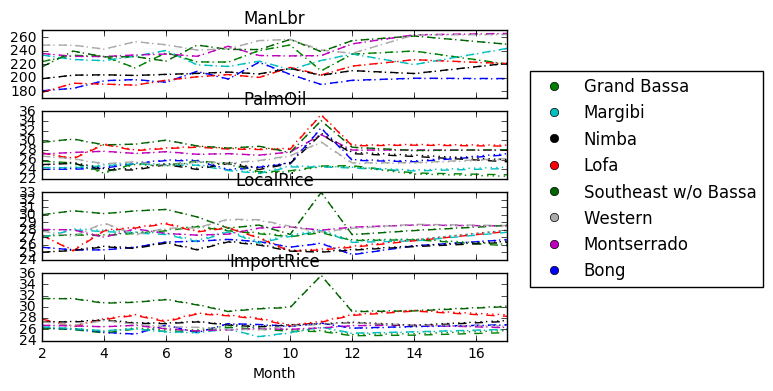

In [63]:
%matplotlib inline

plt.clf()
plt.close()
f, axArray = plt.subplots(4, sharex=True)

colors = dict(zip(panel_series.groups,['b','g','r','c','m','k','darkgreen','darkgray']))

grouped = pd.DataFrame(naive_means,columns=panel_series.variable_names).convert_objects(convert_numeric=True).groupby('StatisticalAggregation')
for key, group in grouped:
    group.plot(ax=axArray[0], kind='line', x='Month', y='ManLbr_Daily', label=key, legend=False, color=colors[key],ls='dashed')
    group.plot(ax=axArray[1], kind='line', x='Month', y='PalmOil_1L', label=key, legend=False, color=colors[key],ls='dashed')
    group.plot(ax=axArray[2], kind='line', x='Month', y='LocalRice_1cup', label=key, legend=False, color=colors[key],ls='dashed')
    group.plot(ax=axArray[3], kind='line', x='Month', y='ImportRice_1cup', label=key, legend=False, color=colors[key],ls='dashed')
    
grouped = pd.DataFrame(rsk_means,columns=panel_series.variable_names).convert_objects(convert_numeric=True).groupby('StatisticalAggregation')
for key, group in grouped:
    group.plot(ax=axArray[0], kind='line', x='Month', y='ManLbr_Daily', label=key, legend=False, color=colors[key],ls='dotted')
    group.plot(ax=axArray[1], kind='line', x='Month', y='PalmOil_1L', label=key, legend=False, color=colors[key],ls='dotted')
    group.plot(ax=axArray[2], kind='line', x='Month', y='LocalRice_1cup', label=key, legend=False, color=colors[key],ls='dotted')
    group.plot(ax=axArray[3], kind='line', x='Month', y='ImportRice_1cup', label=key, legend=False, color=colors[key],ls='dotted')

axArray[0].set_title('ManLbr')
axArray[1].set_title('PalmOil')
axArray[2].set_title('LocalRice')
axArray[3].set_title('ImportRice')
    
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1,loc=2,bbox_to_anchor=(1.05, 4), borderaxespad=0)
plt.show()

In [37]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)

df = pd.DataFrame(naive_means,columns=panel_series.variable_names).convert_objects(convert_numeric=True)
colors = dict(zip(panel_series.groups,['b','g','r','c','m','k','darkgreen','darkgray']))
df['Color'] = df['StatisticalAggregation'].map(colors)
ax1.plot(df['Month'], df['ManLbr_Daily'],  c = df['Color'], alpha = 0.8)


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


ValueError: to_rgba: Invalid rgba arg "0              b
1              g
2              r
3              c
4              m
5              k
6      darkgreen
7       darkgray
8              b
9              g
10             r
11             c
12             m
13             k
14     darkgreen
15      darkgray
16             b
17             g
18             r
19             c
20             m
21             k
22     darkgreen
23      darkgray
24             b
25             g
26             r
27             c
28             m
29             k
         ...    
74             r
75             c
76             m
77             k
78     darkgreen
79      darkgray
80             b
81             g
82             r
83             c
84             m
85             k
86     darkgreen
87      darkgray
88             b
89             g
90             r
91             c
92             m
93             k
94     darkgreen
95      darkgray
96             b
97             g
98             r
99             c
100            m
101            k
102    darkgreen
103     darkgray
Name: Color, dtype: object"
to_rgb: Invalid rgb arg "('b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray', 'b', 'g', 'r', 'c', 'm', 'k', 'darkgreen', 'darkgray')"
sequence length is 104; must be 3 or 4

> c:\program files\anaconda2\lib\site-packages\matplotlib\colors.py(376)to_rgba()
    374         except (TypeError, ValueError) as exc:
    375             raise ValueError(
--> 376                 'to_rgba: Invalid rgba arg "%s"\n%s' % (str(arg), exc))
    377 
    378     def to_rgba_array(self, c, alpha=None):

ipdb> exit()
